In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle as cp
from PIL import ImageFont, ImageDraw, Image
import glob
import arabic_reshaper

In [3]:
with open('../input/imnames.cp.1', 'rb') as f:
  filtered_imnames = set(cp.load(f))

BGS =  list(filtered_imnames)
BGS = ["../input/bg_img/bg_img/"+t for t in BGS]
len(BGS)  
DFTEXT = pd.read_csv("../input/text/english_arabic.csv")
ENGLISH_WORDS = DFTEXT["in English"].tolist()
ARABIC_WORDS = DFTEXT["Arabic"].tolist()
# DFTEXTDFENG["English"].tolist()
PROB_UPPERCASE = 0.5
ENGLISH_FONTS = glob.glob("../input/font_cp/*.ttf")
ARABIC_FONTS = glob.glob("../input/font_ar/*.ttf")
TEXTURES = glob.glob("../input/textures/archive/dtd/images/*/*.jpg")
# ARABIC_FONTS

In [4]:
MAX_NUMBER_OF_WORDS = 4
OPTIONS = ["ENGLISH","ARABIC","ENGLISH AND ARABIC"]


In [24]:
def step1():
    # read bg image
    bg_img = cv2.imread(np.random.choice(BGS))
    # pick a shape for board
    shape_chosen = np.random.choice(["rectangle","circle"],p=[0.5,0.5])
    # pick bg color
    bg_color = list(np.random.randint(low=0, high=255, size=3))
    bg_color = [int(c) for c in bg_color]
    my_img = np.zeros_like(bg_img, dtype = "uint8")
    img_mask = np.zeros_like(bg_img, dtype = "uint8")
    print(shape_chosen,bg_color)
    if shape_chosen == "rectangle":
        cv2.rectangle(my_img, (bg_img.shape[1]//4, bg_img.shape[0]//4), (bg_img.shape[1]*3//4, bg_img.shape[0]*3//4), bg_color, -1)
        cv2.rectangle(img_mask, (bg_img.shape[1]//4, bg_img.shape[0]//4), (bg_img.shape[1]*3//4, bg_img.shape[0]*3//4), (255,255,255), -1)
    else:
        cv2.circle(my_img, (bg_img.shape[1]//2, bg_img.shape[0]//2), min(bg_img.shape[1]//2, bg_img.shape[0]//2), bg_color, -1)
        cv2.circle(img_mask,(bg_img.shape[1]//2, bg_img.shape[0]//2), min(bg_img.shape[1]//2, bg_img.shape[0]//2),  (255,255,255), -1)
    
    num_words = np.random.randint(MAX_NUMBER_OF_WORDS)+1
    eng_phrase = " ".join(np.random.choice(ENGLISH_WORDS,num_words))
    if np.random.random()<PROB_UPPERCASE:
        eng_phrase = eng_phrase.upper()

    num_words = np.random.randint(MAX_NUMBER_OF_WORDS)+1
    ar_phrase = " ".join(np.random.choice(ARABIC_WORDS,num_words))        
    ar_phrase = arabic_reshaper.reshape(ar_phrase)
    ar_phrase = ar_phrase[::-1]
    return my_img,img_mask,bg_img,eng_phrase,ar_phrase


In [25]:
shape,img_mask,bg,eng_phrase,ar_phrase = step1()
eng_phrase,ar_phrase

rectangle [40, 130, 193]


('bit stream describe', 'ﺔﻣﺍﺮﻏ ﺭﺬﺠﻟﺍ ﺐﻫﺬﻟﺍ ﺔﻴﺳﺎﺳﻷﺍ')

In [58]:
def step2(my_img,img_mask,eng_phrase,ar_phrase,option ):
    if option == "ENGLISH":
        fontpath = np.random.choice(ENGLISH_FONTS)
        # pick color
        tx_color = list(np.random.randint(low=0, high=255, size=3))
        tx_color = tuple([int(c) for c in tx_color])
        # pick size
        fontsize = np.random.randint(10,90)
        fontsize = 100
        # pick starting point
        starting_posx = np.random.randint(my_img.shape[1]//6,my_img.shape[1]//3)
        starting_posy = np.random.randint(my_img.shape[0]//6,my_img.shape[0]//3)

        font = ImageFont.truetype(fontpath, fontsize)
        img_pil = Image.fromarray(my_img)
        draw = ImageDraw.Draw(img_pil)
        draw.text((starting_posx, starting_posy), eng_phrase, font = font, fill = tx_color)

        img = np.array(img_pil)
        img = cv2.bitwise_and(img,img_mask)
        font_width,font_height = font.getsize(eng_phrase)
        eng_bboxmask = np.zeros_like(img)
        cv2.rectangle(eng_bboxmask, (starting_posx, starting_posy), (starting_posx+font_width,starting_posy+font_height), (255,255,255), -1)
        ar_bboxmask = None
        return img, eng_bboxmask, ar_bboxmask 
    if option == "ARABIC":
        fontpath = np.random.choice(ARABIC_FONTS)
        # pick color
        tx_color = list(np.random.randint(low=0, high=255, size=3))
        tx_color = tuple([int(c) for c in tx_color])
        # pick size
        fontsize = np.random.randint(10,90)
        fontsize = 90
        # pick starting point
        starting_posx = np.random.randint(my_img.shape[1]//6,my_img.shape[1]//3)
        starting_posy = np.random.randint(my_img.shape[0]//6,my_img.shape[0]//3)

        font = ImageFont.truetype(fontpath, fontsize)
        img_pil = Image.fromarray(my_img)
        draw = ImageDraw.Draw(img_pil)
        draw.text((starting_posx, starting_posy), ar_phrase, font = font, fill = tx_color)

        img = np.array(img_pil)
        img = cv2.bitwise_and(img,img_mask)
        font_width,font_height = font.getsize(ar_phrase)
        ar_bboxmask = np.zeros_like(img)
        cv2.rectangle(ar_bboxmask, (starting_posx, starting_posy), (starting_posx+font_width,starting_posy+font_height), (255,255,255), -1)
        eng_bboxmask = None
        return img, eng_bboxmask, ar_bboxmask 
    if option == "ENGLISH AND ARABIC":
        fontpath = np.random.choice(ENGLISH_FONTS)
        # pick color
        tx_color = list(np.random.randint(low=0, high=255, size=3))
        tx_color = tuple([int(c) for c in tx_color])
        # pick size
        fontsize = np.random.randint(10,90)
        # pick starting point
        starting_posx = np.random.randint(my_img.shape[1]//6,my_img.shape[1]//3)
        starting_posy = np.random.randint(my_img.shape[0]//6,my_img.shape[0]//3)

        font = ImageFont.truetype(fontpath, fontsize)
        img_pil = Image.fromarray(my_img)
        draw = ImageDraw.Draw(img_pil)
        draw.text((starting_posx, starting_posy), eng_phrase, font = font, fill = tx_color)

        img = np.array(img_pil)
        img = cv2.bitwise_and(img,img_mask)
        font_width,font_height = font.getsize(eng_phrase)
        eng_bboxmask = np.zeros_like(img)
        cv2.rectangle(eng_bboxmask, (starting_posx, starting_posy), (starting_posx+font_width,starting_posy+font_height), (255,255,255), -1)
###################ARABIC
        fontpath = np.random.choice(ARABIC_FONTS)
        starting_posx = np.random.randint(my_img.shape[1]//6,my_img.shape[1]//3)
        starting_posy = np.random.randint(my_img.shape[0]//6,my_img.shape[0]//3)

        font = ImageFont.truetype(fontpath, fontsize)
        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)
        draw.text((starting_posx, starting_posy), ar_phrase, font = font, fill = tx_color)

        img = np.array(img_pil)
        img = cv2.bitwise_and(img,img_mask)
        font_width,font_height = font.getsize(ar_phrase)
        ar_bboxmask = np.zeros_like(img)
        cv2.rectangle(ar_bboxmask, (starting_posx, starting_posy), (starting_posx+font_width,starting_posy+font_height), (255,255,255), -1)

        return img, eng_bboxmask, ar_bboxmask 


In [59]:
print(ar_phrase)

ﺔﻣﺍﺮﻏ ﺭﺬﺠﻟﺍ ﺐﻫﺬﻟﺍ ﺔﻴﺳﺎﺳﻷﺍ


In [60]:
OPTIONS = ["ENGLISH","ARABIC","ENGLISH AND ARABIC"]
op = np.random.choice(OPTIONS)
op = 'ENGLISH AND ARABIC'
img, eng_bboxmask, ar_bboxmask  = step2(shape,img_mask,eng_phrase,ar_phrase,op)

ﺔﻣﺍﺮﻏ ﺭﺬﺠﻟﺍ ﺐﻫﺬﻟﺍ ﺔﻴﺳﺎﺳﻷﺍ


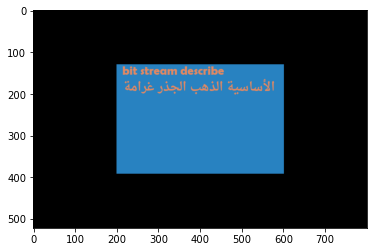

In [61]:
print(ar_phrase)
plt.imshow(img)


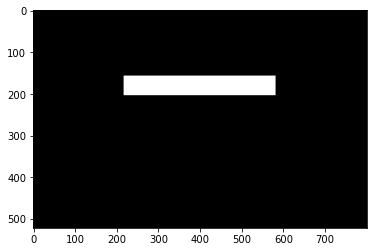

In [62]:
plt.imshow(ar_bboxmask)

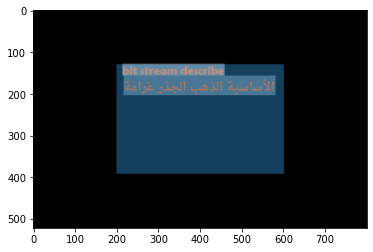

In [63]:
bkbg_img_bb = img.copy()
alpha=0.3
output = cv2.addWeighted(ar_bboxmask, alpha, bkbg_img_bb, 1 - alpha,
		0, bkbg_img_bb)
output = cv2.addWeighted(eng_bboxmask, alpha, output, 1 - alpha,
		0, output)        
plt.imshow(output) 

In [64]:
def step3(eng_bboxmask,ar_bboxmask,img_mask):
    eng_bboxmaks_adj=None
    ar_bboxmaks_adj=None
    if type(eng_bboxmask) != type(None):
        commonbox = cv2.bitwise_and(eng_bboxmask,img_mask)
        im_bw = cv2.cvtColor(commonbox, cv2.COLOR_RGB2GRAY)
        ret,thresh = cv2.threshold(im_bw,127,255,0)
        contours,hierarchy = cv2.findContours(thresh, 1, 2)
        x,y,w,h = cv2.boundingRect(contours[0])
        eng_bboxmaks_adj = np.zeros_like(commonbox)
        cv2.rectangle(eng_bboxmaks_adj,(x,y),(x+w,y+h),(255,255,255),-1)

        
        
    if type(ar_bboxmask) != type(None):
        commonbox = cv2.bitwise_and(ar_bboxmask,img_mask)
        im_bw = cv2.cvtColor(commonbox, cv2.COLOR_RGB2GRAY)
        ret,thresh = cv2.threshold(im_bw,127,255,0)
        contours,hierarchy = cv2.findContours(thresh, 1, 2)
        x,y,w,h = cv2.boundingRect(contours[0])
        ar_bboxmaks_adj = np.zeros_like(commonbox)
        cv2.rectangle(ar_bboxmaks_adj,(x,y),(x+w,y+h),(255,255,255),-1)
    
    # print(len(textures))
    texturefile = np.random.choice(TEXTURES)
    
    texture = cv2.imread(texturefile)
    texture = cv2.resize(texture, (img.shape[1],img.shape[0]), interpolation = cv2.INTER_AREA)
    texture = cv2.cvtColor(texture, cv2.COLOR_BGR2GRAY)
    texture = cv2.cvtColor(texture, cv2.COLOR_GRAY2BGR)

    maskedtexture = cv2.bitwise_and(texture,img_mask)
    mu, sigma = 0.1, 0.05
    s = np.random.normal(mu, sigma, 500)
    s = np.abs(s)

    alpha = np.random.choice(s)
    print(alpha)
    overlaytexture = cv2.addWeighted(maskedtexture, alpha, img, 1 - alpha,
            0, img)
    return overlaytexture,eng_bboxmaks_adj,ar_bboxmaks_adj,w,h


In [65]:
overlaytexture,eng_bboxmaks_adj,ar_bboxmaks_adj,w,h = step3(eng_bboxmask,ar_bboxmask,img_mask)

0.11866368863728674


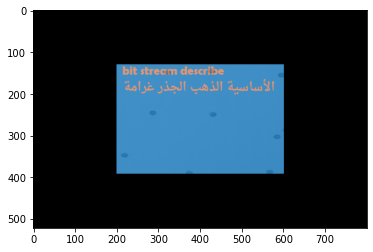

In [66]:
plt.imshow(overlaytexture)

In [70]:
def transform(bg_img,img_mask,overlaytexture,h,w,eng_bboxmaks_adj,ar_bboxmaks_adj,op):
    reboxed_rotated_scaled_ar_bboxmaks_adj,reboxed_rotated_scaled_eng_bboxmaks_adj=None,None
    if op =="ENGLISH":
        max_scale = min(bg_img.shape[0]/h,bg_img.shape[1]/w)
        scalefactor = np.random.randint(10,max_scale*100)/100
        
        scaled = cv2.resize(overlaytexture,(int(bg_img.shape[1]*scalefactor),int(bg_img.shape[0]*scalefactor)), interpolation = cv2.INTER_AREA)
        scaled_img_mask = cv2.resize(img_mask,(int(bg_img.shape[1]*scalefactor),int(bg_img.shape[0]*scalefactor)), interpolation = cv2.INTER_AREA)
        scaled_eng_bboxmaks_adj = cv2.resize(eng_bboxmaks_adj,(int(bg_img.shape[1]*scalefactor),int(bg_img.shape[0]*scalefactor)), interpolation = cv2.INTER_AREA)

        # Random Rotate
        overlaytexture = scaled
        (h__, w__) = overlaytexture.shape[:2]
        center = (w__ // 2, h__ // 2)
        angle = np.random.randint(-10,10)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(scaled, M, (w__, h__),
                flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        rotated_scaled_img_mask  = cv2.warpAffine(scaled_img_mask, M, (w__, h__),
                flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        rotated_scaled_eng_bboxmaks_adj = cv2.warpAffine(scaled_eng_bboxmaks_adj, M, (w__, h__),
            flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

        im_bw = cv2.cvtColor(rotated_scaled_eng_bboxmaks_adj, cv2.COLOR_RGB2GRAY)
        ret,thresh = cv2.threshold(im_bw,127,255,0)
        contours,hierarchy = cv2.findContours(thresh, 1, 2)
        xb,yb,wb,hb = cv2.boundingRect(contours[0])
        reboxed_rotated_scaled_eng_bboxmaks_adj = np.zeros_like(rotated_scaled_eng_bboxmaks_adj)
        cv2.rectangle(reboxed_rotated_scaled_eng_bboxmaks_adj,(xb,yb),(xb+wb,yb+hb),(255,255,255),-1)
        return bg_img,reboxed_rotated_scaled_eng_bboxmaks_adj,reboxed_rotated_scaled_ar_bboxmaks_adj,xb,yb,wb,hb,rotated,rotated_scaled_img_mask
    if op =="ARABIC":
            max_scale = min(bg_img.shape[0]/h,bg_img.shape[1]/w)
            scalefactor = np.random.randint(10,max_scale*100)/100
            
            scaled = cv2.resize(overlaytexture,(int(bg_img.shape[1]*scalefactor),int(bg_img.shape[0]*scalefactor)), interpolation = cv2.INTER_AREA)
            scaled_img_mask = cv2.resize(img_mask,(int(bg_img.shape[1]*scalefactor),int(bg_img.shape[0]*scalefactor)), interpolation = cv2.INTER_AREA)
            scaled_ar_bboxmaks_adj = cv2.resize(ar_bboxmaks_adj,(int(bg_img.shape[1]*scalefactor),int(bg_img.shape[0]*scalefactor)), interpolation = cv2.INTER_AREA)

            # Random Rotate
            overlaytexture = scaled
            (h__, w__) = overlaytexture.shape[:2]
            center = (w__ // 2, h__ // 2)
            angle = np.random.randint(-10,10)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated = cv2.warpAffine(scaled, M, (w__, h__),
                    flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
            rotated_scaled_img_mask  = cv2.warpAffine(scaled_img_mask, M, (w__, h__),
                    flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
            rotated_scaled_ar_bboxmaks_adj = cv2.warpAffine(scaled_ar_bboxmaks_adj, M, (w__, h__),
                flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

            im_bw = cv2.cvtColor(rotated_scaled_ar_bboxmaks_adj, cv2.COLOR_RGB2GRAY)
            ret,thresh = cv2.threshold(im_bw,127,255,0)
            contours,hierarchy = cv2.findContours(thresh, 1, 2)
            xb,yb,wb,hb = cv2.boundingRect(contours[0])
            reboxed_rotated_scaled_ar_bboxmaks_adj = np.zeros_like(rotated_scaled_ar_bboxmaks_adj)
            cv2.rectangle(reboxed_rotated_scaled_ar_bboxmaks_adj,(xb,yb),(xb+wb,yb+hb),(255,255,255),-1)
            return bg_img,reboxed_rotated_scaled_eng_bboxmaks_adj,reboxed_rotated_scaled_ar_bboxmaks_adj,xb,yb,wb,hb,rotated,rotated_scaled_img_mask
    if op =="ENGLISH AND ARABIC":
            max_scale = min(bg_img.shape[0]/h,bg_img.shape[1]/w)
            scalefactor = np.random.randint(10,max_scale*100)/100
            
            scaled = cv2.resize(overlaytexture,(int(bg_img.shape[1]*scalefactor),int(bg_img.shape[0]*scalefactor)), interpolation = cv2.INTER_AREA)
            scaled_img_mask = cv2.resize(img_mask,(int(bg_img.shape[1]*scalefactor),int(bg_img.shape[0]*scalefactor)), interpolation = cv2.INTER_AREA)
            scaled_ar_bboxmaks_adj = cv2.resize(ar_bboxmaks_adj,(int(bg_img.shape[1]*scalefactor),int(bg_img.shape[0]*scalefactor)), interpolation = cv2.INTER_AREA)
            scaled_eng_bboxmaks_adj = cv2.resize(eng_bboxmaks_adj,(int(bg_img.shape[1]*scalefactor),int(bg_img.shape[0]*scalefactor)), interpolation = cv2.INTER_AREA)

            # Random Rotate
            overlaytexture = scaled
            (h__, w__) = overlaytexture.shape[:2]
            center = (w__ // 2, h__ // 2)
            angle = np.random.randint(-10,10)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated = cv2.warpAffine(scaled, M, (w__, h__),
                    flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
            rotated_scaled_img_mask  = cv2.warpAffine(scaled_img_mask, M, (w__, h__),
                    flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
            rotated_scaled_ar_bboxmaks_adj = cv2.warpAffine(scaled_ar_bboxmaks_adj, M, (w__, h__),
                flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
            rotated_scaled_eng_bboxmaks_adj = cv2.warpAffine(scaled_eng_bboxmaks_adj, M, (w__, h__),
                flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

            im_bw = cv2.cvtColor(rotated_scaled_ar_bboxmaks_adj, cv2.COLOR_RGB2GRAY)
            ret,thresh = cv2.threshold(im_bw,127,255,0)
            contours,hierarchy = cv2.findContours(thresh, 1, 2)
            xbar,ybar,wbar,hbar = cv2.boundingRect(contours[0])
            reboxed_rotated_scaled_ar_bboxmaks_adj = np.zeros_like(rotated_scaled_ar_bboxmaks_adj)
            cv2.rectangle(reboxed_rotated_scaled_ar_bboxmaks_adj,(xbar,ybar),(xbar+wbar,ybar+hbar),(255,255,255),-1)

            im_bw = cv2.cvtColor(rotated_scaled_eng_bboxmaks_adj, cv2.COLOR_RGB2GRAY)
            ret,thresh = cv2.threshold(im_bw,127,255,0)
            contours,hierarchy = cv2.findContours(thresh, 1, 2)
            xben,yben,wben,hben = cv2.boundingRect(contours[0])
            reboxed_rotated_scaled_eng_bboxmaks_adj = np.zeros_like(rotated_scaled_eng_bboxmaks_adj)
            cv2.rectangle(reboxed_rotated_scaled_eng_bboxmaks_adj,(xben,yben),(xben+wben,yben+hben),(255,255,255),-1)

            xb = min(xben,xbar)
            yb = min(yben,ybar)
            xend = max(xben+wben,xbar+wbar)
            yend = max(ybar+hbar,yben+hben)
            wb = xend - xb
            hb = yend - yb
            return bg_img,reboxed_rotated_scaled_eng_bboxmaks_adj,reboxed_rotated_scaled_ar_bboxmaks_adj,xb,yb,wb,hb,rotated,rotated_scaled_img_mask
    



In [71]:
bg_img,reboxed_rotated_scaled_eng_bboxmaks_adj,reboxed_rotated_scaled_ar_bboxmaks_adj,xb,yb,wb,hb,rotated,rotated_scaled_img_mask = transform(bg,img_mask,overlaytexture,h,w,eng_bboxmaks_adj,ar_bboxmaks_adj,op)

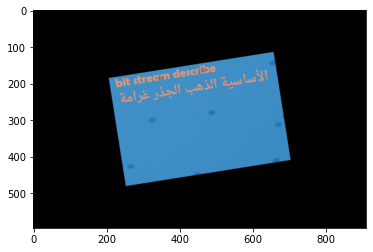

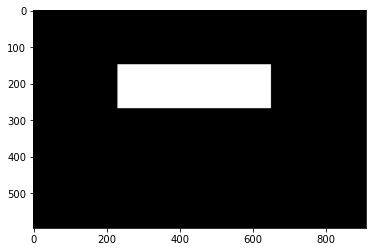

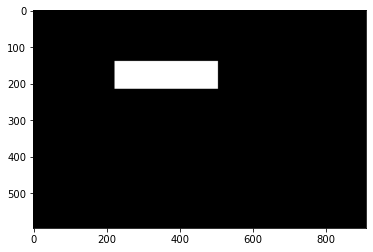

In [72]:
plt.imshow(rotated)
plt.show()
plt.imshow(reboxed_rotated_scaled_ar_bboxmaks_adj)
plt.show()
plt.imshow(reboxed_rotated_scaled_eng_bboxmaks_adj)
plt.show()

In [73]:
def step4(bg_img,reboxed_rotated_scaled_eng_bboxmaks_adj,reboxed_rotated_scaled_ar_bboxmaks_adj,xb,yb,wb,hb,rotated,rotated_scaled_img_mask,op):
    eng_mask_bkbg_img,ar_mask_bkbg_img = None,None
    if op == "ENGLISH":
        bkbg_img = bg_img[:,:,:].copy()
        eng_mask_bkbg_img = np.zeros_like(bkbg_img)
        start_position = (np.random.randint(0,bkbg_img.shape[0]-yb-hb),np.random.randint(0,bkbg_img.shape[1]-xb-wb))
        # start_position = (0,0)
        # start_position = (700,10)# (631, 1271) (638, 1503)
        # start_position=(bkbg_img.shape[0]-yb-hb,bkbg_img.shape[1]-xb-wb)
        print(start_position)
        roi = bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:]
        mask_roi = eng_mask_bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:]
        fg_ = cv2.bitwise_and(rotated[:,:,:3],rotated[:,:,:3],mask=rotated_scaled_img_mask[:,:,0])
        mask_fg_ = cv2.bitwise_and(reboxed_rotated_scaled_eng_bboxmaks_adj[:,:,:3],reboxed_rotated_scaled_eng_bboxmaks_adj[:,:,:3],mask=reboxed_rotated_scaled_eng_bboxmaks_adj[:,:,0])
        # roi = cv2.bitwise_and(roi,roi,mask=cv2.bitwise_not(rotated_scaled_img_mask[:,:,0]))
        roi = cv2.bitwise_and(roi,roi,mask=cv2.bitwise_not(rotated_scaled_img_mask[:roi.shape[0],:roi.shape[1],0]))
        mask_roi = cv2.bitwise_and(mask_roi,mask_roi,mask=cv2.bitwise_not(reboxed_rotated_scaled_eng_bboxmaks_adj[:mask_roi.shape[0],:mask_roi.shape[1],0]))
        dst = cv2.add(roi,fg_[:roi.shape[0],:roi.shape[1],:])
        mask_dst = cv2.add(mask_roi,mask_fg_[:mask_roi.shape[0],:roi.shape[1],:])
        bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:] = dst
        eng_mask_bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:] = mask_dst

        return bkbg_img,eng_mask_bkbg_img,ar_mask_bkbg_img,roi
    if op == "ARABIC":
        bkbg_img = bg_img[:,:,:].copy()
        ar_mask_bkbg_img = np.zeros_like(bkbg_img)
        start_position = (np.random.randint(0,bkbg_img.shape[0]-yb-hb),np.random.randint(0,bkbg_img.shape[1]-xb-wb))
        # start_position = (0,0)
        # start_position = (700,10)# (631, 1271) (638, 1503)
        # start_position=(bkbg_img.shape[0]-yb-hb,bkbg_img.shape[1]-xb-wb)
        print(start_position)
        roi = bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:]
        mask_roi = ar_mask_bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:]
        fg_ = cv2.bitwise_and(rotated[:,:,:3],rotated[:,:,:3],mask=rotated_scaled_img_mask[:,:,0])
        mask_fg_ = cv2.bitwise_and(reboxed_rotated_scaled_ar_bboxmaks_adj[:,:,:3],reboxed_rotated_scaled_ar_bboxmaks_adj[:,:,:3],mask=reboxed_rotated_scaled_ar_bboxmaks_adj[:,:,0])
        # roi = cv2.bitwise_and(roi,roi,mask=cv2.bitwise_not(rotated_scaled_img_mask[:,:,0]))
        roi = cv2.bitwise_and(roi,roi,mask=cv2.bitwise_not(rotated_scaled_img_mask[:roi.shape[0],:roi.shape[1],0]))
        mask_roi = cv2.bitwise_and(mask_roi,mask_roi,mask=cv2.bitwise_not(reboxed_rotated_scaled_ar_bboxmaks_adj[:mask_roi.shape[0],:mask_roi.shape[1],0]))
        dst = cv2.add(roi,fg_[:roi.shape[0],:roi.shape[1],:])
        mask_dst = cv2.add(mask_roi,mask_fg_[:mask_roi.shape[0],:roi.shape[1],:])
        bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:] = dst
        ar_mask_bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:] = mask_dst
        return bkbg_img,eng_mask_bkbg_img,ar_mask_bkbg_img,roi
    if op =="ENGLISH AND ARABIC":
        bkbg_img = bg_img[:,:,:].copy()
        eng_mask_bkbg_img = np.zeros_like(bkbg_img)
        ar_mask_bkbg_img = np.zeros_like(bkbg_img)
        start_position = (np.random.randint(0,bkbg_img.shape[0]-yb-hb),np.random.randint(0,bkbg_img.shape[1]-xb-wb))
        # start_position = (0,0)
        # start_position = (700,10)# (631, 1271) (638, 1503)
        # start_position=(bkbg_img.shape[0]-yb-hb,bkbg_img.shape[1]-xb-wb)
        print(start_position)
        roi = bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:]
        mask_roi = ar_mask_bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:]
        fg_ = cv2.bitwise_and(rotated[:,:,:3],rotated[:,:,:3],mask=rotated_scaled_img_mask[:,:,0])
        mask_fg_ar = cv2.bitwise_and(reboxed_rotated_scaled_ar_bboxmaks_adj[:,:,:3],reboxed_rotated_scaled_ar_bboxmaks_adj[:,:,:3],mask=reboxed_rotated_scaled_ar_bboxmaks_adj[:,:,0])
        mask_fg_eng = cv2.bitwise_and(reboxed_rotated_scaled_eng_bboxmaks_adj[:,:,:3],reboxed_rotated_scaled_eng_bboxmaks_adj[:,:,:3],mask=reboxed_rotated_scaled_eng_bboxmaks_adj[:,:,0])
        # roi = cv2.bitwise_and(roi,roi,mask=cv2.bitwise_not(rotated_scaled_img_mask[:,:,0]))
        roi = cv2.bitwise_and(roi,roi,mask=cv2.bitwise_not(rotated_scaled_img_mask[:roi.shape[0],:roi.shape[1],0]))
        mask_roi_ar = cv2.bitwise_and(mask_roi,mask_roi,mask=cv2.bitwise_not(reboxed_rotated_scaled_ar_bboxmaks_adj[:mask_roi.shape[0],:mask_roi.shape[1],0]))
        mask_roi_eng = cv2.bitwise_and(mask_roi,mask_roi,mask=cv2.bitwise_not(reboxed_rotated_scaled_eng_bboxmaks_adj[:mask_roi.shape[0],:mask_roi.shape[1],0]))
        dst = cv2.add(roi,fg_[:roi.shape[0],:roi.shape[1],:])
        mask_dst_ar = cv2.add(mask_roi,mask_fg_ar[:mask_roi.shape[0],:roi.shape[1],:])
        mask_dst_eng = cv2.add(mask_roi,mask_fg_eng[:mask_roi.shape[0],:roi.shape[1],:])
        bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:] = dst
        ar_mask_bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:] = mask_dst_ar
        eng_mask_bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:] = mask_dst_eng

        return bkbg_img,eng_mask_bkbg_img,ar_mask_bkbg_img,roi


(61, 102)


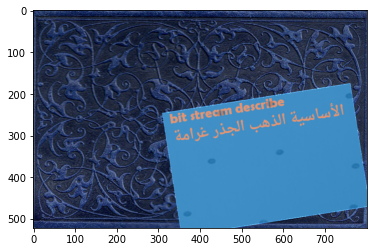

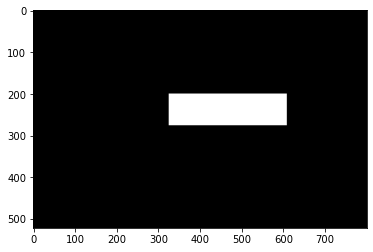

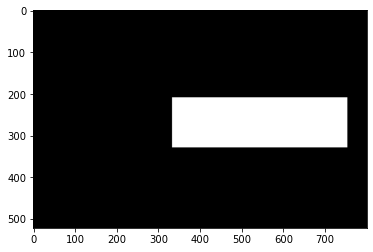

In [74]:
bkbg_img,eng_mask_bkbg_img,ar_mask_bkbg_img,roi = step4(bg_img,reboxed_rotated_scaled_eng_bboxmaks_adj,reboxed_rotated_scaled_ar_bboxmaks_adj,xb,yb,wb,hb,rotated,rotated_scaled_img_mask,op)
plt.imshow(bkbg_img)
plt.show()
plt.imshow(eng_mask_bkbg_img)
plt.show()
plt.imshow(ar_mask_bkbg_img)
plt.show()

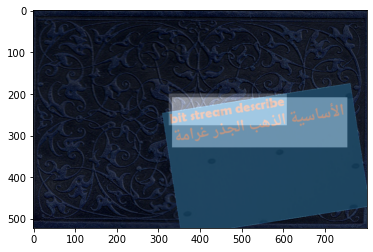

In [75]:
bkbg_img_bb = bkbg_img.copy()
alpha=0.3
output = cv2.addWeighted(eng_mask_bkbg_img, alpha, bkbg_img_bb, 1 - alpha,
		0, bkbg_img_bb)
output = cv2.addWeighted(ar_mask_bkbg_img, alpha, output, 1 - alpha,
		0, output)        
plt.imshow(output) 

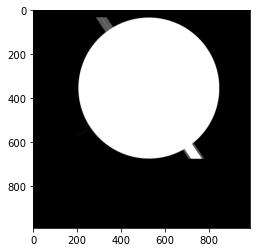

In [236]:
plt.imshow(mask_bkbg_img)

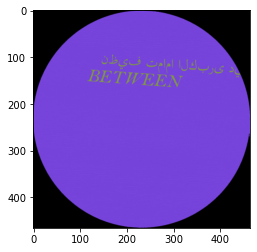

In [284]:
plt.imshow(rotated)

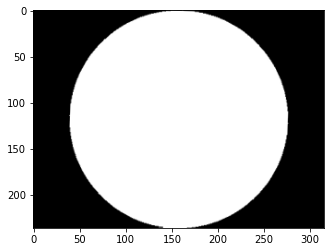

In [171]:
plt.imshow(rotated_scaled_img_mask)

In [190]:
bkbg_img = bg_img[:,:,:].copy()
mask_bkbg_img = np.zeros_like(bkbg_img)

start_position = (np.random.randint(0,bkbg_img.shape[0]-yb-hb),np.random.randint(0,bkbg_img.shape[1]-xb-wb))
roi = bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:]
mask_roi = mask_bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:]
fg_ = cv2.bitwise_and(rotated[:,:,:3],rotated[:,:,:3],mask=reboxed_rotated_scaled_bboxmaks_adj[:,:,0])
mask_fg_ = cv2.bitwise_and(reboxed_rotated_scaled_bboxmaks_adj[:,:,:3],reboxed_rotated_scaled_bboxmaks_adj[:,:,:3],mask=reboxed_rotated_scaled_bboxmaks_adj[:,:,0])
roi = cv2.bitwise_and(roi,roi,mask=cv2.bitwise_not(rotated_scaled_img_mask[:roi.shape[0],:roi.shape[1],0]))
dst = cv2.add(roi,fg_[:roi.shape[0],:roi.shape[1],:])

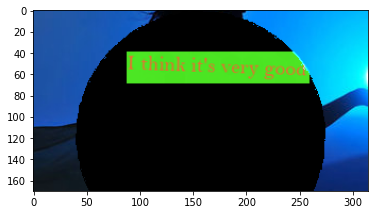

In [191]:
plt.imshow(dst)